(qml101)=
# QML 101 - Some basic concepts

This is the second part of our beginners guide to quantum machine learning. In the last part we introduced some basic notions of classical supervised learning, on which we will build up on. In this tutorial, we will discuss some basic ideas behind quantum machine learning. Hereby, we focus on classifiers, which are part of the big class of supervised (deep) learning algorithms.

The notebook is structured as follows:

- We introduce the learning task of classifying data points $x_i$ with labels $y_i$
- We introduce the circuit structure and the cost function.
- We provide simple training
- We test the performance of the circuit.

We will always focus on simplicity throughout this tutorial and leave the more complex discussions to the extensive literature.

## A simple learning task

For simplicity we will start out with a simple problem, where each data set has only a single variable and extend it later to higher dimensional data sets.

In [ ]:
# only necessary on colab

!pip install qiskit
!pip install pylatexenc

In [ ]:
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


Text(0, 0.5, 'label')

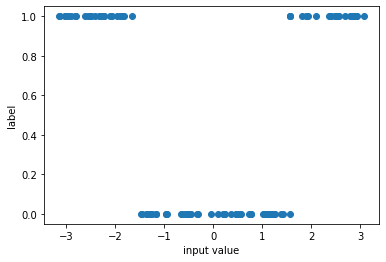

In [ ]:
np.random.seed(1)
x = np.random.uniform(-np.pi, np.pi, 100)
y = 1.0 * (abs(x) > np.pi / 2)

f, ax = plt.subplots()
ax.plot(x, y, "o")
ax.set_xlabel("input value")
ax.set_ylabel("label")

The task will then be to predict the label $y_i$ from the input value $x_i$. To get started we have to divide the data set into a training part and a test part:

- On the *training set* we will optimize the algorithm to achieve the highest possible accuracy in predicting the label.
- On the *test set* we will test the performance of the algorithm with data it has never seen.

The usual problem is here to find a good balance between a sufficient amount of training data, yet leaving enough test data to have a statistically significant test.

In [ ]:
from sklearn.model_selection import train_test_split

Text(0.5, 1.0, 'test data')

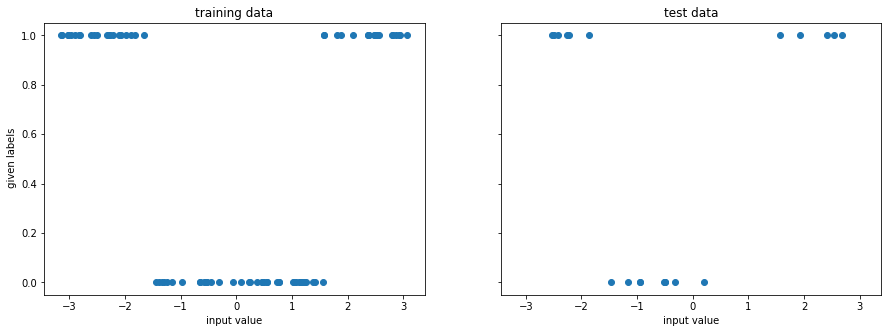

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42
)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax1.plot(x_train, y_train, "o")
ax1.set_xlabel("input value")
ax1.set_ylabel(" given labels")
ax1.set_title("training data")

ax2.plot(x_test, y_test, "o")
ax2.set_xlabel("input value")
ax2.set_title("test data")

## A first algorithm

It is now time to set up the algorithm for the training. Given that there are only two labels, we can directly work with a single qubit. The algorithm is then of the following structure:

1. Prepare the initial state.
2. Apply a parametrized circuit with parameters $\mathbf{w}$ that depend on the input $U(\mathbf{w}, x_i)$.
3. Read out the label from the measurement of the qubit.

In the simplest of all cases, we might then just apply a single qubit rotation with the angle $w x_i$

In [ ]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer

sim = Aer.get_backend("aer_simulator")

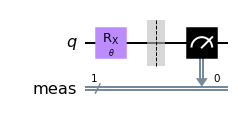

In [ ]:
theta = Parameter(r"$\theta$")

qc = QuantumCircuit(1)
qc.rx(theta, 0)
qc.measure_all()
qc.draw("mpl")

We can now look at the performance of the code with some randomly initialized weight in predicting the appropiate label.

In [ ]:
def get_accuracy(
    qc: QuantumCircuit, weight: float, xvals: List[float], yvals: List[int]
) -> Union[float, List[int]]:
    """
    Calculates the accuracy of the circuit for a given set of data.

    Args:
      qc: the quantum circuit
      weight: the training parameter
      xvals: the input values
      yvals: the labels
    Returns:
      The accuracy and the predicted labels.
    """
    pred_labels = np.zeros(len(xvals))
    accurate_prediction = 0
    for ii, xinput, yinput in zip(range(len(xvals)), xvals, yvals.astype(int)):
        # set the circuit parameter
        circuit = qc.assign_parameters(
            {theta: weight * xinput},
            inplace=False,
        )
        # run the job and obtain the counts
        job = sim.run(circuit, shots=1000)
        counts1 = job.result().get_counts()

        # obtain the predicted label on average
        if "0" in counts1:
            pred_label = 1 * (counts1["0"] < 500)
        else:
            pred_label = 1
        pred_labels[ii] = pred_label
        if yinput == pred_label:
            accurate_prediction += 1
    return accurate_prediction / len(yvals), pred_labels

The circuit has an accuracy of 0.9


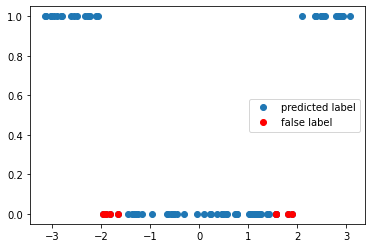

In [ ]:
weight = 0.8

accuracy, y_pred = get_accuracy(qc, weight=weight, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

print(f"The circuit has an accuracy of {accuracy}")
f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

## Training

To improve the performance of the circuit, we have to train it. This basically involves the minimization of some loss function as a function of the circuit parameters $\mathbf{w}$. In this example we can simply calculate the accuracy of the circuit as a function of the weight and obtain its minimimum.

In [ ]:
weights = np.linspace(0, 2, 50)
accuracies = np.zeros(50)

for ii, weight_val in enumerate(tqdm(weights)):
    accuracy, y_pred = get_accuracy(qc, weight=weight_val, xvals=x_train, yvals=y_train)
    accuracies[ii] = accuracy

100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.14it/s]


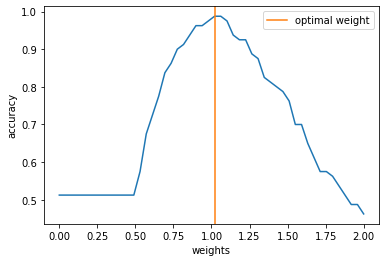

In [ ]:
opt_weight = weights[accuracies.argmax()]

f, ax = plt.subplots()
ax.plot(weights, accuracies)
ax.axvline(opt_weight, color="C1", label="optimal weight")
ax.set_ylabel("accuracy")
ax.set_xlabel("weights")
ax.legend()

We can now test the accuracy on the optimal value of the weights again to obtain.

The trained circuit has an accuracy of 1.0


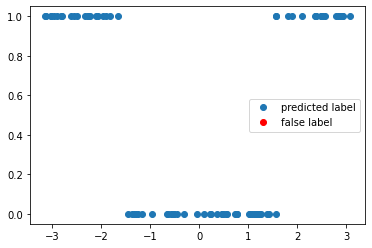

In [ ]:
accuracy, y_pred = get_accuracy(qc, weight=opt_weight, xvals=x_train, yvals=y_train)

false_label = abs(y_pred - y_train) > 0

x_false = x_train[false_label]
y_false = y_pred[false_label]

f, ax = plt.subplots()
ax.plot(x_train, y_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()


print(f"The trained circuit has an accuracy of {accuracy:.2}")

## Test

Having finished the training, we can test the circuit now on data points that it has never seen.

The circuit has a test accuracy of 1.0


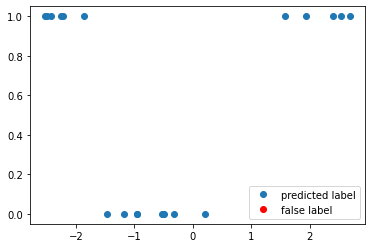

In [ ]:
test_accuracy, y_test_pred = get_accuracy(
    qc, weight=opt_weight, xvals=x_test, yvals=y_test
)

false_label = abs(y_test_pred - y_test) > 0

x_false = x_test[false_label]
y_false = y_test_pred[false_label]

print(f"The circuit has a test accuracy of {test_accuracy:.2}")
f, ax = plt.subplots()
ax.plot(x_test, y_test_pred, "o", label="predicted label")
ax.plot(x_false, y_false, "ro", label="false label")
ax.legend()

## Outlook for supervised learning

In this tutorial, we studied some basic concepts like training and classification for an extremely simple case. 

- In the [next tutorial](qml102), we will see how deeper circuits allow us to learn more complex dependencies between input and output.
- The extension towards higher dimensional inputs allows us to look into more complext tasks like image processing.
